In [1]:
from AStarBase import AStar
import numpy as np
import utils
import matplotlib.pyplot as plt

VoxelMap size: (64, 64, 64)
VoxelMap grid size: [0.144375   0.03546875 0.3129688 ]
VoxelMap min corner: [ -4.62        -0.08500004 -10.015     ]
New start state:  [-4.1  0.5 -8. ]
New start state:  [3.  0.5 7. ]
startStateDescrete [3 4 6]
goalStateDescrete [52  4 54]
Finished in 0.06599545478820801 sec.


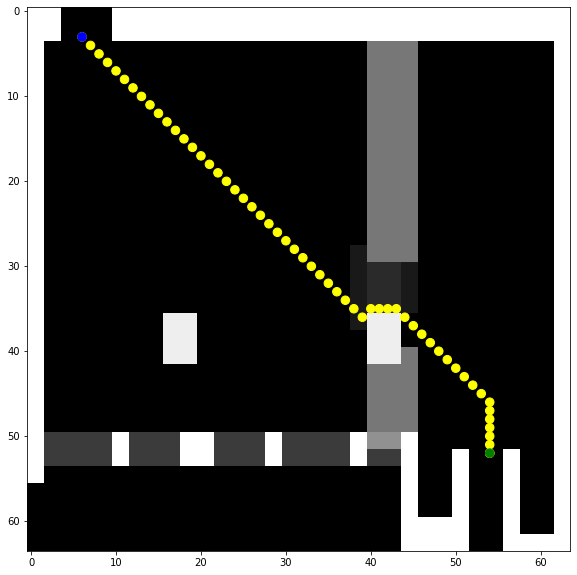

In [2]:
globalPlanner = AStar()
globalPlanner.LoadVoxelMap(full_path = "D:/catkin_ws/src/VRPP_ROS/launch/map.txt")

startState = np.array([-4.1, 0.5, -8.0], dtype=float)
goalState = np.array([3.0, 0.5, 7.0], dtype=float)
globalPlanner.SetStartState(startState)
globalPlanner.SetGoalState(goalState)

if globalPlanner.GetGlobalPlan():
    plan = globalPlanner.GetPlan()

    voxelMap = globalPlanner.GetVoxelMap()
    fig, axes = utils.PlotVoxelProjection(voxelMap)
    for state in plan:
        utils.PlotVoxelStateProjection(axes, state, "yellow")
    
    utils.PlotVoxelStateProjection(axes, globalPlanner.startStateDescrete, "blue")
    utils.PlotVoxelStateProjection(axes, globalPlanner.goalStateDescrete, "green")
    plt.show()